This notebook will be for visualizing the effects of the different data generation methods that we now have at our disposal

In [40]:
from yeastdnnexplorer.probability_models.generate_data import (generate_gene_population, 
                                                               generate_binding_effects,
                                                               generate_pvalues,
                                                               generate_perturbation_effects)

import torch
import matplotlib.pyplot as plt

from yeastdnnexplorer.probability_models.relation_classes import Relation, And, Or
from yeastdnnexplorer.probability_models.generate_data import (
    perturbation_effect_adjustment_function_with_tf_relationships,
    perturbation_effect_adjustment_function_with_tf_relationships_boolean_logic
)

torch.manual_seed(42)  # For CPU
torch.cuda.manual_seed_all(42)  # For all CUDA devices

Generating the binding data is the same as usual (see the notebook titled generate_in_silico_data.ipynb)

In [41]:
# generate the binding data (same as usual)

n_genes = 3000

signal = [0.5, 0.5, 0.5, 0.5, 0.5]
n_sample = [1, 1, 2, 2, 4]

# this will be a list of length 10 with a GenePopulation object in each element
gene_populations_list = []
for signal_proportion, n_draws in zip(signal, n_sample):
    for _ in range(n_draws):
        gene_populations_list.append(generate_gene_population(n_genes, signal_proportion))
        
# Generate binding data for each gene population
binding_effect_list = [generate_binding_effects(gene_population)
                     for gene_population in gene_populations_list]

# Calculate p-values for binding data
binding_pvalue_list = [generate_pvalues(binding_data) for binding_data in binding_effect_list]

binding_data_combined = [torch.stack((gene_population.labels, binding_effect, binding_pval), dim=1)
                         for gene_population, binding_effect, binding_pval
                         in zip (gene_populations_list, binding_effect_list, binding_pvalue_list)]

# Stack along a new dimension (dim=1) to create a tensor of shape [num_genes, num_TFs, 3]
binding_data_tensor = torch.stack(binding_data_combined, dim=1)

Now we can generate datasets using our different mean adjustment functions

In [51]:
tf_relationships = {
    0: [2, 4, 7],
    1: [8],
    2: [3, 9],
    3: [1, 6],
    4: [5],
    5: [0, 2, 8],
    6: [4],
    7: [1, 4],
    8: [6],
    9: [0, 3, 8],
}

tf_relationships_dict_boolean_logic = {
    0: [And(3, 4, 8), Or(3, 7), Or(1, 1)],
    1: [And(5, Or(7, 8))],
    2: [],
    3: [Or(7, 9)],
    4: [And(1, 2)],
    5: [Or(1, 2)],
    6: [And(4, Or(9, 7))],
    7: [Or(5, And(2, 3))],
    8: [And(6, 4)],
    9: [],
}

# generates the perturbation effects for the same gene population N times times
# returns the average perturbation effects for the gene in question for each of the 3 data generation methods
def experiment(n_iterations = 10, GENE_IDX = 0):
    print("Signal (1) and Noise (0) Labels for gene " + str(GENE_IDX) + ":")
    print(binding_data_tensor[GENE_IDX, :, 0])
    num_tfs = sum(n_sample)
    no_mean_adjustment_scores = torch.zeros(num_tfs)
    normal_mean_adjustment_scores = torch.zeros(num_tfs)
    dep_mean_adjustment_scores = torch.zeros(num_tfs)
    boolean_logic_scores = torch.zeros(num_tfs)

    for _ in range(n_iterations):
        perturbation_effects_list_no_mean_adjustment = [generate_perturbation_effects(binding_data_tensor, tf_index=tf_index) for tf_index in range(sum(n_sample))]
        perturbation_effects_list_no_mean_adjustment = torch.stack(perturbation_effects_list_no_mean_adjustment, dim=1)

        perturbation_effects_list_normal_mean_adjustment = [generate_perturbation_effects(binding_data_tensor, tf_index=tf_index, max_mean_adjustment=3.0) for tf_index in range(sum(n_sample))]
        perturbation_effects_list_normal_mean_adjustment = torch.stack(perturbation_effects_list_normal_mean_adjustment, dim=1)

        perturbation_effects_list_dep_mean_adjustment = [generate_perturbation_effects(
            binding_data_tensor, 
            tf_index=tf_index,
            tf_relationships=tf_relationships,
            adjustment_function=perturbation_effect_adjustment_function_with_tf_relationships,
        ) for tf_index in range(sum(n_sample))]
        perturbation_effects_list_dep_mean_adjustment = torch.stack(perturbation_effects_list_dep_mean_adjustment, dim=1)

        perturbation_effects_list_boolean_logic = [generate_perturbation_effects(
            binding_data_tensor, 
            tf_index=tf_index,
            adjustment_function=perturbation_effect_adjustment_function_with_tf_relationships_boolean_logic,
            tf_relationships=tf_relationships_dict_boolean_logic,
        ) for tf_index in range(sum(n_sample))]
        perturbation_effects_list_boolean_logic = torch.stack(perturbation_effects_list_boolean_logic, dim=1)

        
        no_mean_adjustment_scores += abs(perturbation_effects_list_no_mean_adjustment[GENE_IDX, :])
        normal_mean_adjustment_scores += abs(perturbation_effects_list_normal_mean_adjustment[GENE_IDX, :])
        dep_mean_adjustment_scores += abs(perturbation_effects_list_dep_mean_adjustment[GENE_IDX, :])
        boolean_logic_scores += abs(perturbation_effects_list_boolean_logic[GENE_IDX, :])
        
    
    no_mean_adjustment_scores /= n_iterations
    normal_mean_adjustment_scores /= n_iterations
    dep_mean_adjustment_scores /= n_iterations
    boolean_logic_scores /= n_iterations
    
    return no_mean_adjustment_scores, normal_mean_adjustment_scores, dep_mean_adjustment_scores, boolean_logic_scores


In [52]:
GENE_IDX = 0

print(binding_data_tensor[GENE_IDX, :, 0])

experiment_results = experiment(n_iterations=100, GENE_IDX=GENE_IDX)
print(experiment_results[0])
print(experiment_results[1])
print(experiment_results[2])
print(experiment_results[3])

tensor([0., 0., 0., 1., 1., 1., 1., 1., 0., 1.])
Signal (1) and Noise (0) Labels for gene 0:
tensor([0., 0., 0., 1., 1., 1., 1., 1., 0., 1.])
tensor([0.8034, 0.8110, 0.7002, 2.9490, 2.8607, 2.8937, 2.9745, 2.9070, 0.8482,
        3.2078])
tensor([0.6831, 0.7741, 0.7762, 0.8352, 0.7205, 0.8622, 0.8508, 0.9262, 0.7629,
        0.8891])
tensor([0.7483, 0.9065, 0.7777, 3.0852, 2.9497, 2.9220, 3.0397, 3.2685, 0.7769,
        2.9825])
tensor([0.8453, 0.8854, 0.8249, 2.8476, 3.0134, 2.9312, 3.1590, 3.0933, 0.7864,
        2.8976])


tensor([0., 0., 0., 1., 1., 1., 1., 1., 0., 1.])


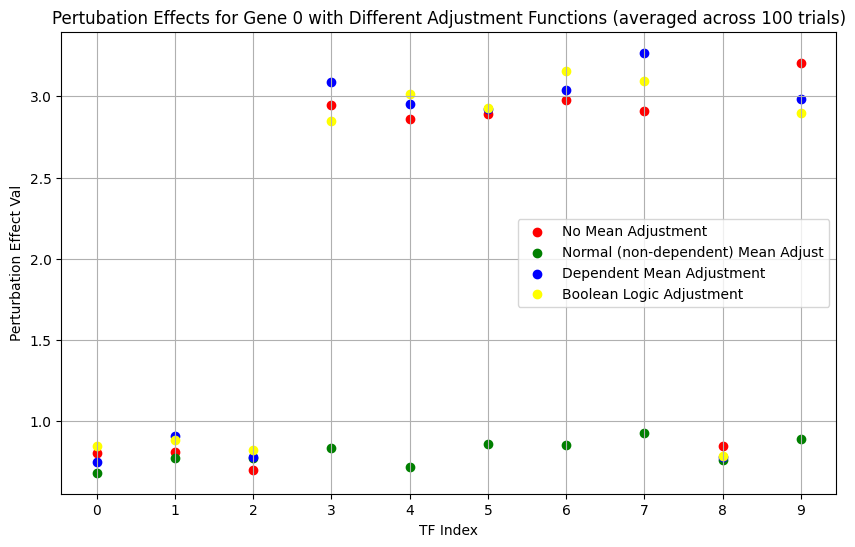

In [53]:
x_vals = list(range(sum(n_sample)))
print(binding_data_tensor[GENE_IDX, :, 0])
plt.figure(figsize=(10, 6))

# Plot each set of experiment results with a different color
colors = ['red', 'green', 'blue', 'yellow']
for index, results in enumerate(experiment_results):
    plt.scatter(x_vals, results, color=colors[index])

plt.title('Pertubation Effects for Gene ' + str(GENE_IDX) + ' with Different Adjustment Functions (averaged across 100 trials)')
plt.xlabel('TF Index')
plt.ylabel('Perturbation Effect Val')
plt.xticks(x_vals)
plt.grid(True)
plt.legend(['No Mean Adjustment', 'Normal (non-dependent) Mean Adjust', 'Dependent Mean Adjustment', 'Boolean Logic Adjustment'])
plt.show()